In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 4.9 MB/s 
     |████████████████████████████████| 4.4 MB 53.2 MB/s 
     |████████████████████████████████| 197 kB 65.9 MB/s 
     |████████████████████████████████| 362 kB 63.6 MB/s 
     |████████████████████████████████| 1.2 MB 66.4 MB/s 
     |████████████████████████████████| 60 kB 9.9 MB/s 
     |████████████████████████████████| 140 kB 73.7 MB/s 
     |████████████████████████████████| 212 kB 72.2 MB/s 
     |████████████████████████████████| 1.1 MB 53.0 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 60.0 MB/s 
     |████████████████████████████████| 127 kB 77.2 MB/s 
     |████████████████████████████████| 271 kB 41.8 MB/s 
     |████████████████████████████████| 144 kB 73.8 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [7]:
(path/'13').ls()

(#972) [Path('/root/.fastai/data/biwi_head_pose/13/frame_00103_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00185_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00015_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00125_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00029_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00383_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00445_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00052_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00195_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00144_rgb.jpg')...]

In [8]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/13/frame_00103_pose.txt')

In [9]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

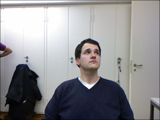

In [10]:
im.to_thumb(160)

In [19]:
with open(path/'01'/'rgb.cal', 'r') as f:
  print(f.readlines())

['517.679 0 320 \n', '0 517.679 240.5 \n', '0 0 1 \n', '\n', '0 0 0 0 \n', '\n', '0.999947 0.00432361 0.00929419 \n', '-0.00446314 0.999877 0.0150443 \n', '-0.009228 -0.015085 0.999844 \n', '\n', '-24.0198 5.8896 -13.2308 \n', '\n', '640 480\n']


In [17]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

In [21]:
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1, c2])

In [23]:
get_ctr(img_files[0])

tensor([374.1092, 224.8003])

In [25]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)

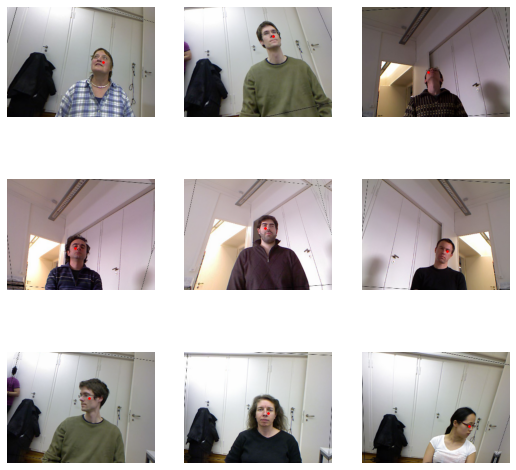

In [26]:
dls = biwi.dataloaders(path)
dls.show_batch()

In [27]:
dls.loss_func

FlattenedLoss of MSELoss()

In [33]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [30]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
learn.model(xb)

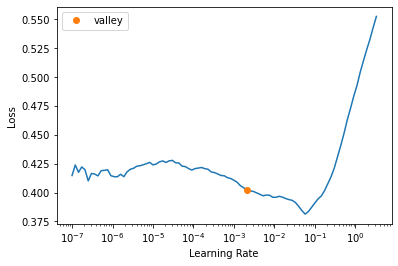

In [34]:
best_lr = learn.lr_find().valley

In [ ]:
learn.fine_tune()

In [36]:
learn.fit_one_cycle(5, best_lr)

epoch,train_loss,valid_loss,time
0,0.171286,0.006285,02:03
1,0.014976,0.001997,02:04
2,0.007880,0.001174,02:02
3,0.005224,0.000786,02:03
4,0.004160,0.000859,02:00
